## ReAct Agent

In [1]:
## Create a workflow
import operator
from typing import List, TypedDict, Annotated, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

## Load LLM model
model = 'deepseek-r1-distill-llama-70b'
llm = ChatGroq(model=model)

In [3]:
response = llm.invoke("what is the second longest wall after great wall of china. Is it in India? Give output in 5 line only")
print(response.content)

<think>
Okay, so I need to figure out what the second longest wall in the world is after the Great Wall of China, and whether it's located in India. I'm not entirely sure about this, so I'll have to think it through step by step.

First, I know the Great Wall of China is the longest. It's really famous and I've heard it's over 13,000 miles long. Now, for the second longest, I'm not certain. I've heard of other walls in different countries, but I'm not sure which one is the next in line.

I remember something about the Great Wall of Gorgan in Iran. I think it's also known as the Red Snake because of the red color of the bricks. But I'm not 100% sure if that's the second longest. Maybe there's another wall in India that's longer?

Wait, I think India does have some historical walls and forts, but I'm not sure if any of them are the second longest. I've heard of the Kumbhalgarh Fort in Rajasthan, which has a long wall, but is it the second longest in the world? I'm not sure. I think it's 

In [4]:
from langchain.tools import tool

In [5]:
@tool
def add(a:int,b:int) -> int:
    '''
    Add two integers
    
    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of a and b.
    '''
    pass

@tool
def multiply(a:int,b:int) -> int:
    '''
    Multiply two integers
    
    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    '''
    pass

@tool
def divide(a:int,b:int) -> float:
    '''
    divide two integers
    
    Args:
        a (int): The numerator.
        b (int): The denominator (must not be 0).
        
    Returns:
        float: The result of division.
    '''
    pass

Import the inbuilt tool

In [6]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [7]:
search.invoke('What is latest updated on Air India Crash')

"Air India plane crash latest: Airline carrying out Boeing 787 safety checks as families reunited with victims Air India's Boeing 787 fleet could be grounded temporarily An Air India flight bound for London crashed shortly after taking off in the western city of Ahmedabad, killing all but one of the 242 people on board. Ahmedabad Plane Crash Updates:Investigators recovered the black box of the ill-fated Air India Boeing 787-8 Dreamliner (AI171) from the rooftop of a medical college hostel, a day after it crashed in Ahmedabad, killing 241 of the 242 on board. The Aircraft Accident Investigation Bureau confirmed the retrieval of the Digital Flight Data Recorder, key to understanding the crash. Following the ... The Air India flight fell from the sky on Thursday and killed at least 270 people in Gujarat state, officials said Saturday. All but one of the 242 people on board the London-bound flight died when it crashed into a residential area in Ahmedabad shortly after take-off."

In [8]:
## Tool list
tools_list = [multiply, add, divide, search]
## binding llm with tool
llm_with_tool = llm.bind_tools(tools_list)

In [9]:
response = llm_with_tool.invoke('Hi')
print(response.content)
print(response.tool_calls)

Hello! How can I assist you today?
[]


In [10]:
response = llm_with_tool.invoke('what is 2+2')
print(response.content)
print(response.tool_calls)


[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'fcgmsfh1a', 'type': 'tool_call'}]


In [11]:
response = llm_with_tool.invoke('What is the current age of TATA Group')
print(response.content)
print(response.tool_calls)

The TATA Group was founded in 1868, so as of 2023, it is 155 years old.
[]


In [12]:
def function_1(state: MessagesState):
    return {'messages':[llm_with_tool.invoke(state['messages'])]}

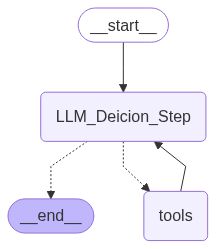

In [13]:
builder = StateGraph(MessagesState)
builder.add_node('LLM_Deicion_Step',function_1)
builder.add_node('tools', ToolNode(tools_list))
builder.add_edge(START, 'LLM_Deicion_Step')
builder.add_conditional_edges(
    'LLM_Deicion_Step',
    tools_condition
)
builder.add_edge('tools','LLM_Deicion_Step')
app = builder.compile()
app

In [14]:
message = [HumanMessage(content='Hi')]
app.invoke({'messages':message})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='467bbba2-4676-4da0-8217-e34464ce9273'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fse3g0fzt', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 371, 'prompt_tokens': 388, 'total_tokens': 759, 'completion_time': 1.7401277259999999, 'prompt_time': 0.025083882, 'queue_time': 0.219178138, 'total_time': 1.765211608}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d4c30c16-0cf7-4f64-9c1e-81f83c6651c9-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'fse3g0fzt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 388, 'output_tokens': 371, 'total_tokens': 759}),
  ToolMessage(content='null', name='multiply', id='b512fe4a-88cc-4458-949c-a55e3327776c', tool_call_id='fse3g0f

In [15]:
message = [HumanMessage(content='what is 2+2')]
app.invoke({'messages':message})

{'messages': [HumanMessage(content='what is 2+2', additional_kwargs={}, response_metadata={}, id='0c122847-ed00-4212-82fc-04784321bc9d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9bbckf6cv', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 167, 'prompt_tokens': 393, 'total_tokens': 560, 'completion_time': 0.696137427, 'prompt_time': 0.025451698, 'queue_time': 0.24169015200000002, 'total_time': 0.721589125}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ab2344b4-30d4-45a0-bcd4-68c3f9382aea-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': '9bbckf6cv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 393, 'output_tokens': 167, 'total_tokens': 560}),
  ToolMessage(content='null', name='add', id='1a97603c-9dd2-4782-855b-67fd8a82cf7d', tool_call_id='9bbckf6cv'),

In [16]:
SYSTEM_PROMPT = "YOu are a helpful assistant taked with using search and performing airthmetic operations on a set of inputs"

In [23]:
import operator
from typing import List, TypedDict, Annotated, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode

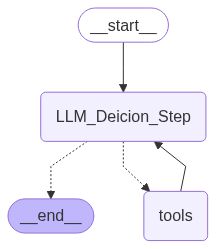

In [18]:
#SYSTEM_PROMPT = [SystemMessage(content="YOu are a helpful assistant taked with using search and performing airthmetic operations on a set of inputs")]

def function_1(state:MessagesState) :
    
    user_question = state['messages']
    print(user_question)
    input_question = [SYSTEM_PROMPT] + user_question
    print(input_question)
    
    response = llm_with_tool.invoke(input_question)
    
    return {'messages':[response]}

## Workflow
builder2 = StateGraph(MessagesState)
builder2.add_node('LLM_Deicion_Step',function_1)
builder2.add_node('tools', ToolNode(tools_list))
builder2.add_edge(START, 'LLM_Deicion_Step')
builder2.add_conditional_edges(
    'LLM_Deicion_Step',
    tools_condition
)
builder2.add_edge('tools','LLM_Deicion_Step')
app2 = builder.compile()
app2

In [95]:
llm_with_tool.invoke('What is the 2 times of narendra modi age')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x44pghqwx', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 271, 'prompt_tokens': 399, 'total_tokens': 670, 'completion_time': 0.993199064, 'prompt_time': 0.035484208, 'queue_time': 0.06273113, 'total_time': 1.028683272}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_e98d30d035', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1a9e3eba-d7d9-404f-8f51-f7cfe5167fec-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi age'}, 'id': 'x44pghqwx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 399, 'output_tokens': 271, 'total_tokens': 670})

In [20]:
message = [HumanMessage(content='What is the 2 times of narendra modi age')]
app2.invoke({'messages':message})

{'messages': [HumanMessage(content='What is the 2 times of narendra modi age', additional_kwargs={}, response_metadata={}, id='d63a1ed7-e3cd-4ab8-9b30-bf5fd6a54dae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mvbdsb4zg', 'function': {'arguments': '{"a":73,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 448, 'prompt_tokens': 399, 'total_tokens': 847, 'completion_time': 1.828805075, 'prompt_time': 0.028145035, 'queue_time': 0.21701987299999997, 'total_time': 1.85695011}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--24122e4d-353f-400f-b683-6d85c825f608-0', tool_calls=[{'name': 'multiply', 'args': {'a': 73, 'b': 2}, 'id': 'mvbdsb4zg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 399, 'output_tokens': 448, 'total_tokens': 847}),
  ToolMessage(content='null', name='multiply', id='b03741b8-90fa-40b0-a